In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="custom.css">

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import fudebako

pd.options.display.float_format = '{:.2f}'.format

n225_df = pd.read_csv('./data/nikkei_stock_average_daily_jp.csv',
                      parse_dates=True, index_col=['Date'])
vi_df = pd.read_csv('./data/nikkei_stock_average_vi_daily_jp.csv',
                    parse_dates=True, index_col=['Date'])

n225_vi_df = pd.concat([n225_df['Close'], vi_df['Close']], axis=1)
n225_vi_df.columns = ['N225', 'VI']

# ケーススタディ

### 2018年4月限 @2018年3月2日

### 考察してみよう
* 先物価格はどのように推移しているか
* ボラティリティはどのような特徴をもっているか
* 有効とされるオプション戦略はあるか

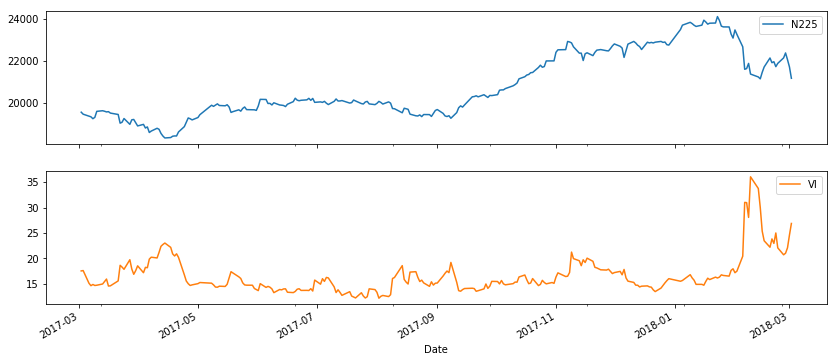

In [3]:
n225_vi_df.loc['2017-03-02':'2018-03-02'].plot(figsize=(14, 6), subplots=True);

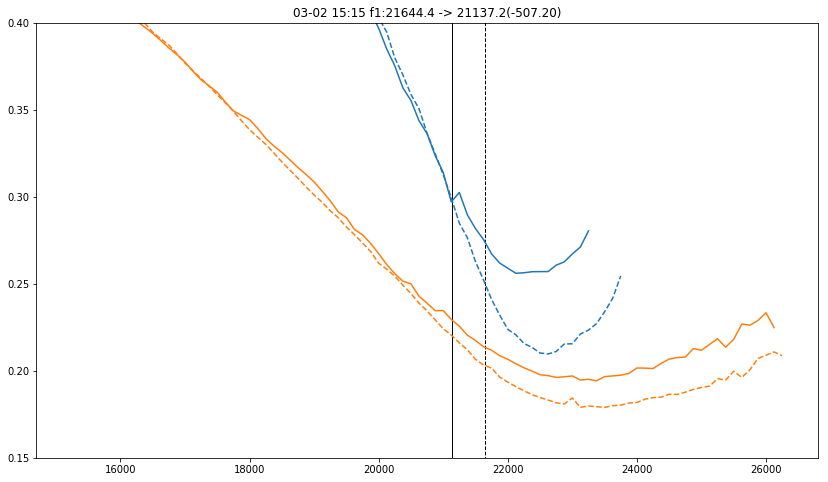

In [4]:
prev1, prev2 = fudebako.get_fop_data(fudebako.s_df.index[12])
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
prev1, prev2 = fudebako.plot_iv(fudebako.s_df.index[13], ax, prev1, prev2)
ax.set_ylim(0.15, 0.4)
plt.show()

### 所感の一例

* 短期間で先物が急落
* コールのボラティリティが著しく上昇
* FOTMプットは反応せず

### 戦略の一例 #1

* 先物が反発(上昇)するとコールのボラティリティが低下するのでは？
* カバードコール戦略を考えてみる

In [5]:
t0 = fudebako.s_df.index[13]
p1 = fudebako.Portfolio()
p1.add(t0, 1, 1, 'F')
p1.add(t0, -10, 1, 'C', 23000)
display(p1.position[['code', 'qty', 'a_price', 'iv', 'delta', 'gamma', 'vega', 'theta']])
print(p1.position[['delta', 'gamma', 'vega', 'theta']].sum())

,code,qty,a_price,iv,delta,gamma,vega,theta
0,1804F,1.00,20974.10,nan,1.00,0.00,0.00,0.00
1,1804C23000,-10.00,55.80,0.20,-0.89,-1.15,-11395.36,26.95


delta        0.11
gamma       -1.15
vega    -11395.36
theta       26.95
dtype: float64



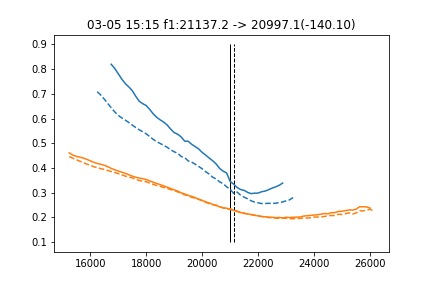

In [6]:
t0 = fudebako.s_df.index[14]
p1.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p1, t0, prev1, prev2)
H


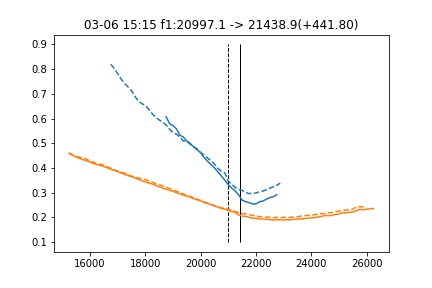

In [7]:
t0 = fudebako.s_df.index[15]
p1.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p1, t0, prev1, prev2)
H


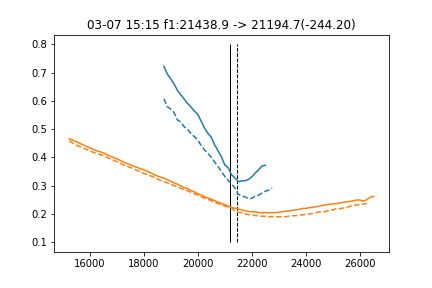

In [8]:
t0 = fudebako.s_df.index[16]
p1.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p1, t0, prev1, prev2)
H


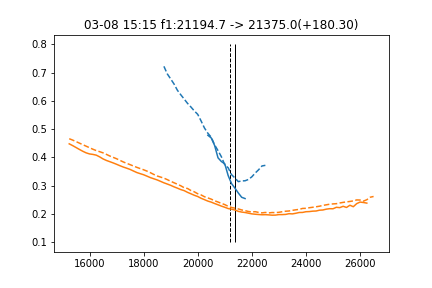

In [9]:
t0 = fudebako.s_df.index[17]
p1.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p1, t0, prev1, prev2)
H

### 戦略の一例 #2

* 期近のボラティリティが反応して逆ザヤが広がっている
* 落ち着けばサヤが縮小するのでは
* カレンダー戦略を考えてみる

In [10]:
t0 = fudebako.s_df.index[13]
prev1, prev2 = fudebako.get_fop_data(t0)
p2 = fudebako.Portfolio()
p2.add(t0, -1, 0, 'C', 22000)
p2.add(t0, 1, 1, 'C', 22500)
# p2.add(t0, 0.1, 1, 'F')
display(p2.position[['code', 'qty', 'a_price', 'iv', 'delta', 'gamma', 'vega', 'theta']])
print(p2.position[['delta', 'gamma', 'vega', 'theta']].sum())

,code,qty,a_price,iv,delta,gamma,vega,theta
0,1803C22000,-1.00,48.45,0.26,-0.13,-0.29,-612.91,11.78
1,1804C22500,1.00,110.25,0.20,0.16,0.17,1690.59,-4.01


delta      0.02
gamma     -0.12
vega    1077.68
theta      7.77
dtype: float64



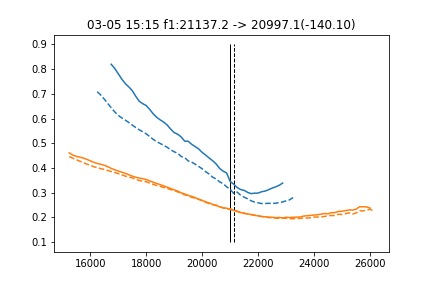

In [11]:
t0 = fudebako.s_df.index[14]
p2.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p2, t0, prev1, prev2)
H


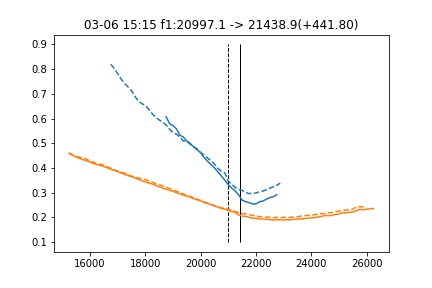

In [12]:
t0 = fudebako.s_df.index[15]
p2.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p2, t0, prev1, prev2)
H


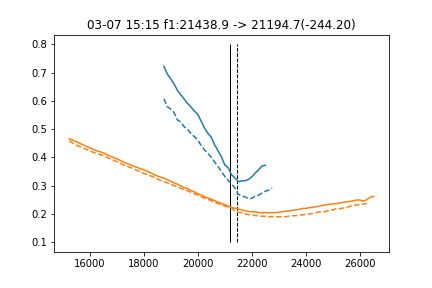

In [13]:
t0 = fudebako.s_df.index[16]
p2.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p2, t0, prev1, prev2)
H


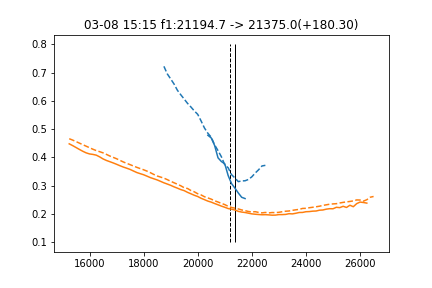

In [14]:
t0 = fudebako.s_df.index[17]
p2.update(t0)
H, prev1, prev2 = fudebako.draw_dashboard(p2, t0, prev1, prev2)
H